In [1]:
import pandas as pd
import numpy as np

# visuals
import seaborn as sns
import matplotlib.pyplot as plt

# Support Functions

In [2]:
def get_df_null_info(df):
    # analzyse sparse columns (= many NaNs/Null-Values)
    nulls:pd.Series =df.isnull().sum(axis = 0).sort_values(ascending = False)
    df_null_info:pd.DataFrame = pd.DataFrame(data={
        'nulls_amount': nulls,
        'nulls_percentage': nulls.apply(lambda row: round((row/df.shape[0])*100,2))
    })
    return df_null_info

# Get to know the data

In [3]:
#import
df_source = pd.read_csv("germany_housing_data_14.07.2020.csv", sep=",")

df_null_info = get_df_null_info(df_source)
df_null_info

,nulls_amount,nulls_percentage
Energy_consumption,8119,76.94
Year_renovated,5203,49.31
Usable_area,4984,47.23
Energy_efficiency_class,4819,45.67
Bedrooms,3674,34.82
Free_of_Relation,3569,33.82
Energy_certificate_type,3526,33.42
Furnishing_quality,2726,25.83
Floors,2664,25.25
Garages,1960,18.57


In [4]:
df_source.describe(include="all")

,Unnamed: 0,Price,Type,Living_space,Lot,Usable_area,Free_of_Relation,Rooms,Bedrooms,Bathrooms,...,Energy_source,Energy_certificate,Energy_certificate_type,Energy_consumption,Energy_efficiency_class,State,City,Place,Garages,Garagetype
count,10552.000000,1.055200e+04,10150,10552.000000,10552.000000,5568.000000,6983,10552.000000,6878.000000,8751.000000,...,9325,9797,7026,2433.000000,5733,10551,10551,10262,8592.000000,8592
unique,NaN,NaN,11,NaN,NaN,NaN,705,NaN,NaN,NaN,...,104,3,2,NaN,9,16,534,4762,NaN,7
top,NaN,NaN,Mid-terrace house,NaN,NaN,NaN,nach Absprache,NaN,NaN,NaN,...,Gas,available,demand certificate,NaN,D,Nordrhein-Westfalen,Hannover (Kreis),Innenstadt,NaN,Garage
freq,NaN,NaN,4324,NaN,NaN,NaN,1383,NaN,NaN,NaN,...,4528,6987,4143,NaN,970,1660,107,32,NaN,4412
mean,5275.500000,5.566851e+05,NaN,216.721008,1491.659004,134.300424,NaN,7.388978,4.169817,2.308993,...,NaN,NaN,NaN,117.663111,NaN,NaN,NaN,NaN,2.698673,NaN
std,3046.244354,6.087410e+05,NaN,172.421321,8582.361675,188.814089,NaN,5.378126,2.577169,1.742330,...,NaN,NaN,NaN,54.023207,NaN,NaN,NaN,NaN,3.195068,NaN
min,0.000000,0.000000e+00,NaN,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,0.000000,...,NaN,NaN,NaN,5.100000,NaN,NaN,NaN,NaN,1.000000,NaN
25%,2637.750000,2.500000e+05,NaN,130.000000,370.000000,48.000000,NaN,5.000000,3.000000,1.000000,...,NaN,NaN,NaN,83.170000,NaN,NaN,NaN,NaN,1.000000,NaN
50%,5275.500000,4.052150e+05,NaN,176.775000,656.500000,80.000000,NaN,6.000000,4.000000,2.000000,...,NaN,NaN,NaN,112.700000,NaN,NaN,NaN,NaN,2.000000,NaN
75%,7913.250000,6.550000e+05,NaN,250.000000,1047.000000,150.250000,NaN,8.000000,5.000000,3.000000,...,NaN,NaN,NaN,146.000000,NaN,NaN,NaN,NaN,3.000000,NaN


# Pre-Processing

### Data Reduction

In [5]:
# Drop all columns:
#  (a) with more than 26% null values
#  (b) 'City' & 'Place' because  'State', 'City', and 'Place' have same information but with different granularity
drop_col_percentage_treshold=26
cols_to_drop = list(df_null_info[(df_null_info['nulls_percentage'] > drop_col_percentage_treshold)].index.values) 
cols_to_drop.append('City')
cols_to_drop.append('Place')
print(f'Drop following columns: {cols_to_drop}')

df_source.drop(columns=cols_to_drop, inplace=True)

Drop following columns: ['Energy_consumption', 'Year_renovated', 'Usable_area', 'Energy_efficiency_class', 'Bedrooms', 'Free_of_Relation', 'Energy_certificate_type', 'City', 'Place']


### Data Cleaning (handle noisy & missing data)

In [6]:
df_null_info = get_df_null_info(df_source)
df_null_info

,nulls_amount,nulls_percentage
Furnishing_quality,2726,25.83
Floors,2664,25.25
Garagetype,1960,18.57
Garages,1960,18.57
Bathrooms,1801,17.07
Energy_source,1227,11.63
Energy_certificate,755,7.16
Year_built,694,6.58
Heating,584,5.53
Type,402,3.81


Start to clean each column.

In [7]:
# for column 'City' drop all rows with no city
df_source.drop(df_source[df_source['State'].isnull()].index, inplace=True)
df_source.loc[df_source['State'].isnull()]

# for all other columns: fill NaNs with mode value
for col in df_source:
    df_source[col].fillna(df_source[col].mode()[0], inplace=True)

In [8]:
df_source

,Unnamed: 0,Price,Type,Living_space,Lot,Rooms,Bathrooms,Floors,Year_built,Furnishing_quality,Condition,Heating,Energy_source,Energy_certificate,State,Garages,Garagetype
0,0,498000.0,Multiple dwelling,106.00,229.0,5.5,1.0,2.0,2005.0,normal,modernized,central heating,Gas,available,Baden-Württemberg,2.0,Parking lot
1,1,495000.0,Mid-terrace house,140.93,517.0,6.0,2.0,2.0,1994.0,basic,modernized,stove heating,Gas,not required by law,Baden-Württemberg,7.0,Parking lot
2,2,749000.0,Farmhouse,162.89,82.0,5.0,2.0,4.0,2013.0,normal,dilapidated,stove heating,"Fernwärme, Bioenergie",available,Baden-Württemberg,1.0,Garage
3,3,259000.0,Farmhouse,140.00,814.0,4.0,2.0,2.0,1900.0,basic,fixer-upper,central heating,Strom,available,Baden-Württemberg,1.0,Garage
4,4,469000.0,Multiple dwelling,115.00,244.0,4.5,1.0,2.0,1968.0,refined,refurbished,central heating,Öl,available,Baden-Württemberg,1.0,Garage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10547,10547,1495000.0,Special property,167.00,683.0,6.5,3.0,2.0,1976.0,normal,first occupation after refurbishment,stove heating,Fernwärme,available,Bayern,1.0,Garage
10548,10548,449000.0,Mid-terrace house,222.00,4000.0,6.0,3.0,1.0,2017.0,normal,dilapidated,oil heating,Erdwärme,available,Sachsen-Anhalt,4.0,Parking lot
10549,10549,678000.0,Mid-terrace house,142.00,377.0,4.0,2.0,2.0,2021.0,basic,dilapidated,central heating,Gas,available,Bayern,2.0,Garage
10550,10550,419900.0,Mid-terrace house,120.83,501.0,5.0,1.0,2.0,2019.0,normal,modernized,stove heating,Gas,available,Sachsen-Anhalt,1.0,Garage


/home/korosu/miniconda3/envs/study-lab/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Floors'>

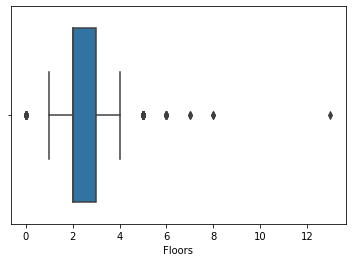

In [9]:


#plt.figure (figsize=(16,5))  
#plt.subplot(1,2,1)
#sns.distplot(df_source['Price'])
#plt.subplot(1,2,2)
#sns.distplot(df_source['Bathrooms'])
#plt.show()
sns.boxplot(df_source['Floors'])


# categorical data
# df_source['Garagetype'].value_counts().plot(kind='bar')

### Data Transformation (How to handle outliers?)
- one hot encoding   (categorical data)
- how to handle outliers (numerical data)

In [10]:
df_source.dtypes

Unnamed: 0              int64
Price                 float64
Type                   object
Living_space          float64
Lot                   float64
Rooms                 float64
Bathrooms             float64
Floors                float64
Year_built            float64
Furnishing_quality     object
Condition              object
Heating                object
Energy_source          object
Energy_certificate     object
State                  object
Garages               float64
Garagetype             object
dtype: object

In [11]:
## remove outlier: z_score transformation


# get all numerical columns
cols_to_zscore = list(df_source.select_dtypes(include='float64'))
cols_to_zscore.remove("Price")
cols_zscore = []

# create df with zscore-columns 
for col in cols_to_zscore:
    col_zscore = col + '_zscore'
    cols_zscore.append(col_zscore)
    
    # zscore of x in column :    (x- col.mean)-col.std
    # -> add an extra column for zscore
    df_source[col_zscore] = (df_source[col] - df_source[col].mean())/df_source[col].std(ddof=0)


In [12]:
cols_zscore
#[df_source.columns.get_loc(c) for c in cols_zscore]


#df_source['Result'] = (df_source.iloc[:, 1:4].values < df_source[['E']].values).all(axis=1)


['Living_space_zscore',
 'Lot_zscore',
 'Rooms_zscore',
 'Bathrooms_zscore',
 'Floors_zscore',
 'Year_built_zscore',
 'Garages_zscore']

In [43]:
treshhold = 1
treshhold_range = [-treshhold, treshhold]

df_source["max_zscore"] = df_source[cols_zscore].max(axis=1) 
df_source['min_zscore'] = df_source[cols_zscore].min(axis=1) 


df_source['is_outlier'] = (
    (treshhold <= df_source["max_zscore"]) | 
    (df_source["max_zscore"] <= -treshhold ) | 

    (treshhold  <= df_source["min_zscore"]) | 
    (df_source["min_zscore"]  <= -treshhold ) 
)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

/home/korosu/miniconda3/envs/study-lab/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Floors'>

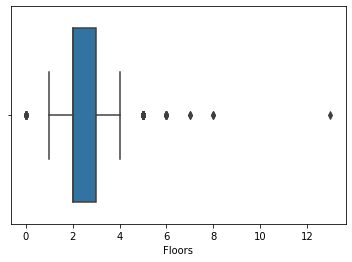

In [39]:
df_new = df_source[df_source['is_outlier'] == False]
print(len(df_source[df_source['is_outlier'] == True]))

sns.boxplot(df_new['Floors'])
